# *E.coli* Transcription Network Analysis

Author: Lakshay Sood

In [270]:
import warnings
warnings.filterwarnings("ignore")

## Visualizing the graph

I chose to analyze data from this paper; 

*Shen-Orr et. al, "Network motifs in the transcriptional regulation network of Escherichia coli." Nature Genetics 31, 64-68 (2002).*

I am interested in uncovering relationships between operons that control the metabolic state of the cell and operons that control cell division. In the context of this paper, these relationships arise when a transcription factor from one operon regulates expression of the other operon.

Before we do this, we have to understand some basic properties of the graph. 

In [271]:
import graph_tool.all as gt 
import networkx as nx 
import pyintergraph # For conversion of graph_tool object to networkx object 
from graspologic.plot import heatmap
import pandas as pd
pd.set_option('display.max_rows', None)

g = gt.collection.ns["ecoli_transcription/v1.0"]
g = pyintergraph.gt2nx(g)

operons = pd.read_table('/Users/lakshaysood/Desktop/JHU/Junior_Year/networks-course/ColiNet-1.0/coliInterFullNames.txt', delim_whitespace=True, header=None)

labels = [operon for operon in operons.iloc[:, 1]]

num_nodes = len(list(g.nodes))
num_edges = len(list(g.edges))

print(f"The graph has {num_nodes} nodes and {num_edges} edges. This is in comparison to {num_nodes * (num_nodes - 1)} potential edges.")

The graph has 424 nodes and 577 edges. This is in comparison to 179352 potential edges.


So this is a (very) sparse matrix representing an unweighted, directed network. Let's visualize its adjacency matrix and a network representation below; 

<AxesSubplot:>

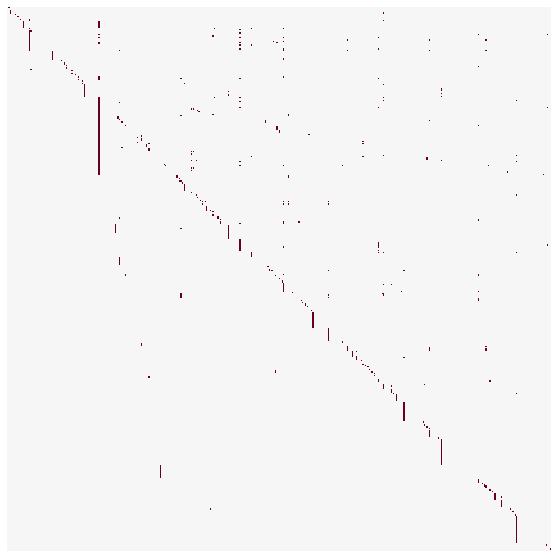

In [272]:
from scipy.sparse import csr_matrix

nodelist = list(g.nodes)
A = nx.to_scipy_sparse_matrix(g, nodelist=nodelist)
heatmap(g, cbar=False)
# https://towardsdatascience.com/visualizing-a-sparse-matrix-1c4c807ea6c9 if I want to plot the matrix alone

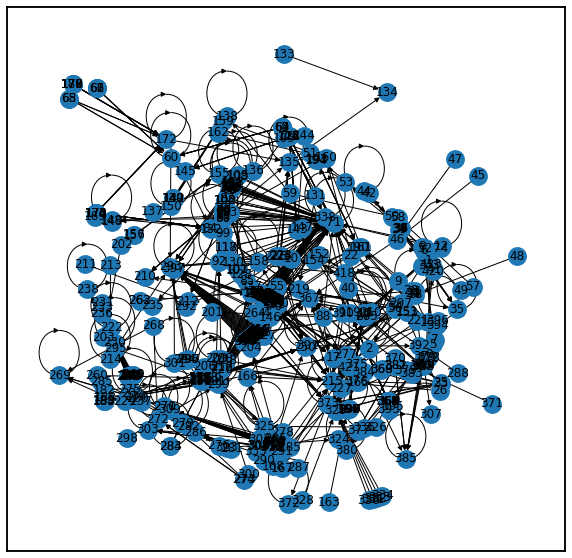

In [273]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
pos = nx.kamada_kawai_layout(g)

nx.draw_networkx(g, pos=pos, ax=ax)

If we want to visualize the network free of self-loops, we can do the following: 

The new graph has 424 nodes and 519 edges. This is in comparison to 179352 potential edges.


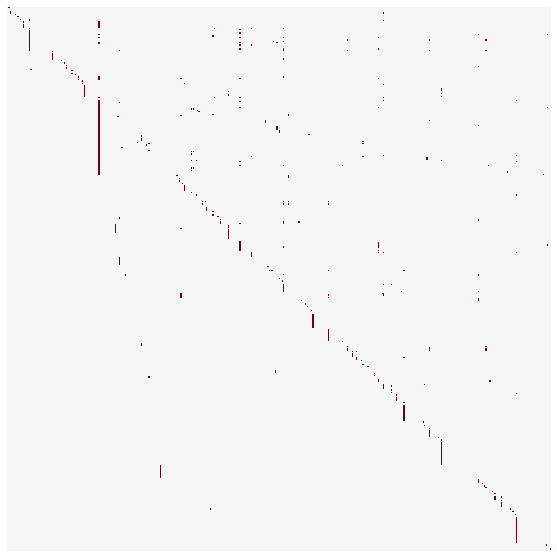

In [274]:
g.remove_edges_from(nx.selfloop_edges(g))
heatmap(g, cbar=False)

num_nodes = len(list(g.nodes))
num_edges = len(list(g.edges))

print(f"The new graph has {num_nodes} nodes and {num_edges} edges. This is in comparison to {num_nodes * (num_nodes - 1)} potential edges.")

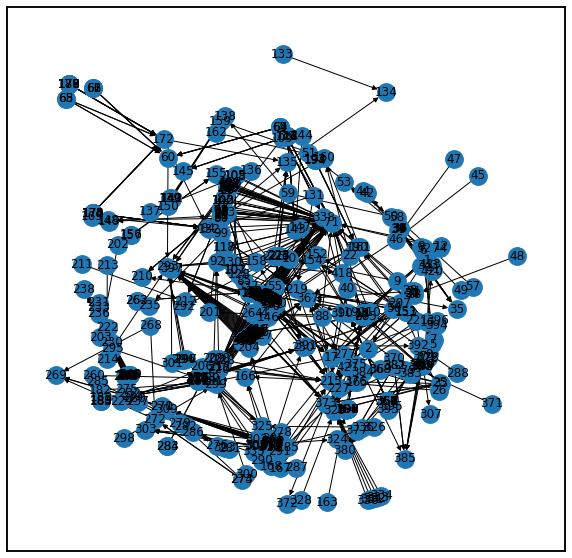

In [275]:
fig1, ax1 = plt.subplots(1, 1, figsize=(10, 10))
pos1 = nx.kamada_kawai_layout(g)

nx.draw_networkx(g, pos=pos1, ax=ax1)

## Centrality measures

The first thing we can do is to identify the most important nodes in the network. I hypothesize that these operons will control the operations necessary for cellular survival - for example, operons that control the production of essential amino acids, or those that stimulate cellular division. 

One way to define operon importance is to consider the number of downstream operons regulated by an operon. The most important operons have the highest out-degrees in the graph. 

In [276]:
import numpy as np

A = nx.to_scipy_sparse_matrix(g, nodelist=nodelist) # necessary to do again since we removed self-loops 

out_degrees = np.ravel(A.sum(axis=1))
sorted_out_degree_indices = np.argsort(out_degrees)[::-1]
out_degrees = out_degrees[sorted_out_degree_indices]
sorted_operons = np.array(labels)[sorted_out_degree_indices]
operon_dict = {sorted_operons[i]: out_degrees[i] for i in range(len(out_degrees))}
operon_dict

{'aroF_tyrA': 6,
 'fepA_entD': 5,
 'fumA': 5,
 'arcA': 5,
 'appCBA': 4,
 'argX_hisR_leuT_proM': 4,
 'ilvC': 4,
 'argF': 4,
 'argD': 4,
 'fur': 4,
 'araFG_araH_1H_2': 4,
 'caiF': 4,
 'cysJIH': 4,
 'cvpA_purF_ubiX': 4,
 'fdhF': 4,
 'hipBA': 4,
 'hcaA1A2CBD_yphA': 3,
 'cadC': 3,
 'dmsABC': 3,
 'glnALG': 3,
 'nac': 3,
 'ecpD_htrE': 3,
 'hcaR': 3,
 'glmUS': 3,
 'cydAB': 3,
 'mtr': 3,
 'dctA': 3,
 'inaA': 3,
 'gyrA': 3,
 'dapA_nlpB_purA': 3,
 'fepDGC': 3,
 'cysK': 3,
 'fdnGHI': 3,
 'lacZYA': 3,
 'argR': 3,
 'leuX': 3,
 'livJ': 3,
 'livKHMGF': 3,
 'evgA': 3,
 'fabA': 3,
 'fadBA': 3,
 'argE': 3,
 'fadR': 2,
 'fixABCX': 2,
 'dnaA': 2,
 'fadL': 2,
 'edd_eda': 2,
 'flgAMN': 2,
 'fhuACDB': 2,
 'glpD': 2,
 'dcuB_fumB': 2,
 'motABcheAW': 2,
 'flgBCDEFGHIJK': 2,
 'cytR': 2,
 'exuT': 2,
 'glpFK': 2,
 'dsbA': 2,
 'ecfF': 2,
 'cysPUWAM': 2,
 'ecfK': 2,
 'ecfJ': 2,
 'ecfI': 2,
 'glpTQ': 2,
 'ecfG': 2,
 'entCEBA': 2,
 'dsdC': 2,
 'glpR': 2,
 'ecfABC': 2,
 'ebgR': 2,
 'ebgAC': 2,
 'epd_pgk': 2,
 'dsdXA': 2

In [277]:
def regulated_genes(n, graph, index_list, operon_list, labels): # pick the highest n operons and see what genes their transcription factors regulate
    edge_list = list(graph.edges)
    num_edges = len(edge_list)
    for i in range(10): 
        print("\n" + f"{i + 1}. " + operon_list[i] + "\n")
        for j in range(num_edges): 
            if edge_list[j][0] == index_list[i]: 
                out_node = edge_list[j][1]
                print(labels[out_node])

regulated_genes(10, g, sorted_out_degree_indices, sorted_operons, labels)
        


1. aroF_tyrA

appY
deoR
lacI
mtlADR
rbsDACBK
tnaLAB

2. fepA_entD

cyaA
gntT
lacI
modE
torCAD

3. fumA

fumC
galETKM
lacI
metH
leuO

4. arcA

appY
cyaA
gntT
lacI
ompA

5. appCBA

appY
himD
lacI
gcvTHP

6. argX_hisR_leuT_proM

appY
gntT
lacI
ompA

7. ilvC

idnDOTR
ilvIH
metH
ppsA

8. argF

appY
cyaA
gntT
katG

9. argD

appY
mtlADR
rbsDACBK
tnaLAB

10. fur

fumC
lacI
metH
leuO


But this method of defining operon importance lacks nuance. If an operon has a high out-degree, but most of the operons it regulates have an out-degree of zero, it is less important than an operon that has a high out-degree with child operons that also have high out-degrees. 

Another way to define node importance is to use eigenvector centrality. Briefly, nodes are considered important if they are connected to other nodes. The entries of the eigenvector for the largest eigenvalue of the adjacency matrix represent each node's eigenvector centrality. Thus, although the definition in words seems circular, the mathematical definition avoids this circularity. 

We could also use subgraph centrality. This method determines the importance of a node by enumerating the number of subgraphs that include that node. Unfortunately, networkx does not define a subgraph_centrality method for digraphs. Symmetrizing the graph to make it an undirected graph would introduce extra edges, which would change the subgraph centrality of each node from the original graph. 

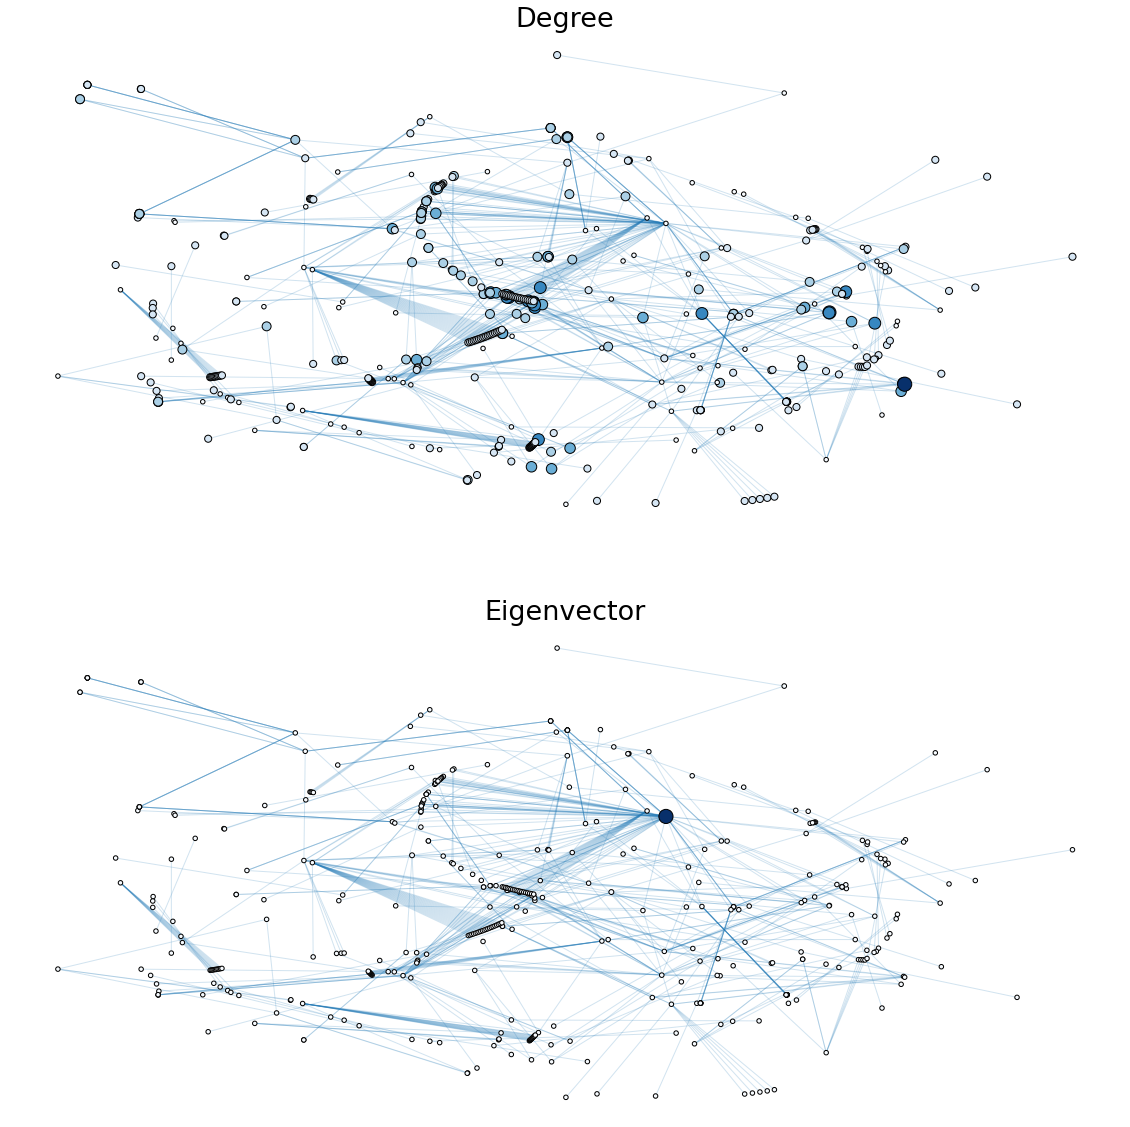

In [278]:
import seaborn as sns
from matplotlib import colors
from graspologic.plot import networkplot

old_g = gt.collection.ns["ecoli_transcription/v1.0"]
old_g = pyintergraph.gt2nx(old_g)
old_A = nx.to_scipy_sparse_matrix(old_g, nodelist=nodelist)

operon_index_dict = {sorted_out_degree_indices[i]: out_degrees[i] for i in range(len(out_degrees))}
node_data = pd.DataFrame(index=g.nodes())
node_data["degree"] = node_data.index.map(operon_index_dict)
node_data["eigenvector"] = node_data.index.map(nx.eigenvector_centrality(old_g, max_iter=10000))

pos = nx.kamada_kawai_layout(g)
node_data["x"] = [pos[node][0] for node in node_data.index]
node_data["y"] = [pos[node][1] for node in node_data.index]

sns.set_context("talk", font_scale=1.5)
fig, axs = plt.subplots(2, 1, figsize=(20, 20))


def plot_node_scaled_network(A, node_data, key, ax):
    # REF: https://github.com/mwaskom/seaborn/blob/9425588d3498755abd93960df4ab05ec1a8de3ef/seaborn/_core.py#L215

    levels = list(np.sort(node_data[key].unique()))
    cmap = sns.color_palette("Blues", as_cmap=True)
    vmin = np.min(levels)
    norm = colors.Normalize(vmin=0.3 * vmin)
    palette = dict(zip(levels, cmap(norm(levels))))

    networkplot(
        A,
        node_data=node_data,
        x="x",
        y="y",
        ax=ax,
        edge_linewidth=1.0,
        node_size=key,
        node_hue=key,
        palette=palette,
        node_sizes=(20, 200),
        node_kws=dict(linewidth=1, edgecolor="black"),
        node_alpha=1.0,
        edge_kws=dict(color=sns.color_palette()[0])
    )

    ax.axis("off")
    ax.set_title(key.capitalize())


ax = axs[0]
plot_node_scaled_network(A, node_data, "degree", ax)

ax = axs[1]
plot_node_scaled_network(old_A, node_data, "eigenvector", ax)


Comparing the out-degree centrality to the eigenvector centrality, we see that the most important node in the eigenvector network does not have a high out-degree. So for our purposes, eigenvector centrality is not a good measure of the most important nodes in the network. 

## Community detection 

At this point I wanted to move on and find communities in the network using the Leiden algorithm for agglomerative clustering. Unfortunately, graspologic's implementation of the Leiden algorithm only works for undirected graphs. Converting my graph to an undirected graph seems infeasible: 

In [336]:
print(nx.reciprocity(old_g))
print(nx.reciprocity(g))

0.0
0.0


I found a library online, written by the first author of the Leiden paper, that would allow me to work with the algorithm on directed graphs. While the algorithm seemed to work, I had to convert my NetworkX graph to an iGraph, which reindexes all of the nodes and edges, and I didn't have time to figure out how to recover the original node indices. Also, plotting the communities by color was really finicky in iGraph, and I didn't have time to figure out how to do it the right way. I'm including my attempt below for completeness, but in the future I'd like to figure ways around these two problems. 

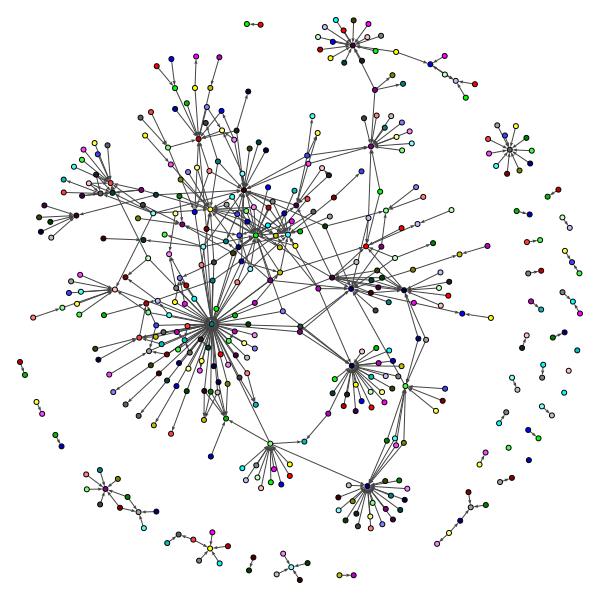

In [337]:
import leidenalg as la # Necessary because graspologic implementation of Leiden algorithm doesn't work for 
                       # directed graphs, but this implementation claims to work (written by original author of
                       # Leiden paper)
import igraph as ig 

ig_g = ig.Graph.from_networkx(g)
leiden_partition_map = la.find_partition(ig_g, la.ModularityVertexPartition);
pal = ig.drawing.colors.ClusterColoringPalette(len(leiden_partition_map))
ig_g.vs['color'] = pal.get_many(pal)
layout = ig_g.layout_kamada_kawai()
ig.plot(ig_g, vertex_size=5, edge_arrow_size=1/3, edge_arrow_width=1, vertex_color = ig_g.vs['color'])

## Graph matching

Finally, I will compare the structure of the largest connected component of my network to a directed configuration model. In this model, you specify the in- and out-degree distribution of each node, but allow the nodes to form connections with other nodes at random, similar to the degree-connected ER model. 

This model has several pros and cons. The biggest point in favor of this model is that the degree distribution will approximate the real network as closely as possible, which enables direct comparison of the two graphs. However, self-loops and multiple edges between two nodes are possible under NetworkX's implementation. I decided that these two would not be significant impediments because the probability of these two events occuring goes to zero as network size increases. 

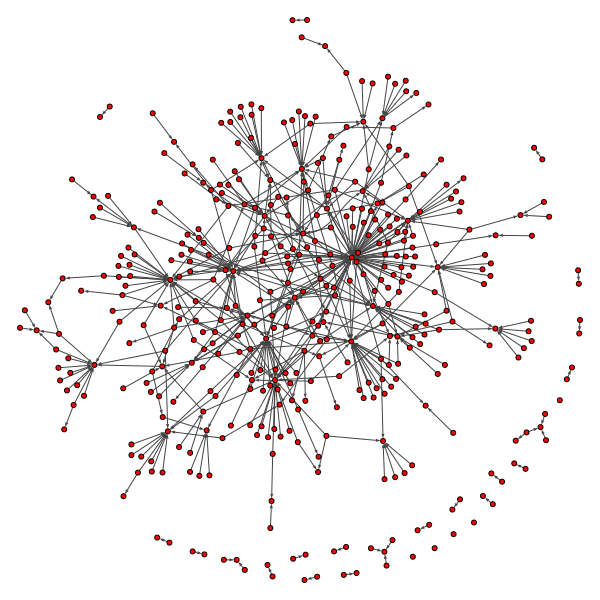

In [342]:
from graspologic.utils import largest_connected_component

new_g = largest_connected_component(old_g)
new_nodelist = list(new_g.nodes())
new_A = nx.to_scipy_sparse_matrix(new_g, nodelist=new_nodelist)

new_in_degrees = np.ravel(A.sum(axis=0))
new_out_degrees = np.ravel(A.sum(axis=1))
dcmg = nx.directed_configuration_model(new_in_degrees, new_out_degrees)
dcmg = nx.DiGraph(dcmg)
dcmg.remove_edges_from(nx.selfloop_edges(dcmg))

ig_dcmg = ig.Graph.from_networkx(dcmg)
ig.plot(ig_dcmg, vertex_size=5, edge_arrow_size=1/3, edge_arrow_width=1)

## Conclusions